# Case Study for Probabilistic Disease Spread

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
def run_sir_simulation(G, beta, gamma, initial_infected_nodes, max_iterations=100):
    N = G.number_of_nodes()
    susceptible = np.ones(N, dtype=bool)
    infected = np.zeros(N, dtype=bool)
    recovered = np.zeros(N, dtype=bool)

    susceptible[initial_infected_nodes] = False
    infected[initial_infected_nodes] = True

    iteration_results = []
    iteration = 0

    iteration_results.append({
        'iteration': iteration,
        'status': {i: (0 if susceptible[i] else 1 if infected[i] else 2) for i in range(N)}
    })

    while infected.sum() > 0 and iteration < max_iterations:
        iteration += 1
        new_infected = infected.copy()
        new_recovered = recovered.copy()

        for node in range(N):
            if infected[node]:
                if random.random() < gamma:
                    new_infected[node] = False
                    new_recovered[node] = True
            elif susceptible[node]:
                neighbors = list(G.predecessors(node))
                infective_neighbors = sum(infected[neighbor] for neighbor in neighbors)
                if infective_neighbors >= 1:
                    for _ in range(infective_neighbors):
                        if random.random() < beta:
                            new_infected[node] = True
                            susceptible[node] = False
                            break

        infected = new_infected
        recovered = new_recovered

        iteration_results.append({
            'iteration': iteration,
            'status': {i: (0 if susceptible[i] else 1 if infected[i] else 2) for i in range(N)}
        })

    return iteration_results

In [4]:
def conditional_probability_iteration(G, beta, gamma, initial_infected_nodes, tol=0.001):
    N = G.number_of_nodes()
    status = np.zeros((N, 3))

    for node in G.nodes():
        if node in initial_infected_nodes:
            status[node, 1] = 1
        else:
            status[node, 0] = 1

    s = status[:, 0]
    i = status[:, 1]
    r = status[:, 2]

    iteration_results = []
    t = 0

    iteration_results.append({
        'iteration': t,
        'susceptible': {node: s[node] for node in G.nodes()},
        'infected': {node: i[node] for node in G.nodes()},
        'recovered': {node: r[node] for node in G.nodes()}
    })

    while max(i) > tol:
        t += 1
        for node in G.nodes():
            in_neighbors = list(G.predecessors(node))
            s_new = np.prod([1 - beta * i[x] for x in in_neighbors]) * s[node]
            i_new = s[node] - s_new + i[node] * (1 - gamma)
            r_new = r[node] + i[node] * gamma

            s[node] = s_new
            i[node] = i_new
            r[node] = r_new

        iteration_results.append({
            'iteration': t,
            'susceptible': {node: s[node] for node in G.nodes()},
            'infected': {node: i[node] for node in G.nodes()},
            'recovered': {node: r[node] for node in G.nodes()}
        })

    return iteration_results

In [5]:
def visualize_iteration(G, monte_carlo_results, ground_truth_results, iteration, node_positions):
    plt.figure(figsize=(14, 7))

    monte_carlo_status = monte_carlo_results[iteration]['status']
    monte_carlo_colors = [
        'blue' if monte_carlo_status[node] == 0 else 'red' if monte_carlo_status[node] == 1 else 'green'
        for node in G.nodes()
    ]
    plt.subplot(1, 2, 1)
    nx.draw(
        G,
        pos=node_positions,
        node_color=monte_carlo_colors,
        with_labels=True,
        labels={node: f"{node}" for node in G.nodes()},
        node_size=500
    )
    plt.title(f"Monte Carlo Simulation at Iteration {iteration}")

    ground_truth_s = ground_truth_results[iteration]['susceptible'] if iteration < len(ground_truth_results) else ground_truth_results[-1]['susceptible']
    ground_truth_colors = [ground_truth_s[node] for node in G.nodes()]
    plt.subplot(1, 2, 2)
    nx.draw(
        G,
        pos=node_positions,
        node_color=ground_truth_colors,
        cmap=plt.cm.Blues,
        with_labels=True,
        labels={node: f"{node}\n{s:.2f}" for node, s in ground_truth_s.items()},
        node_size=500
    )
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Susceptible Probability')
    plt.title("Ground Truth Susceptible Probabilities")

    plt.show()


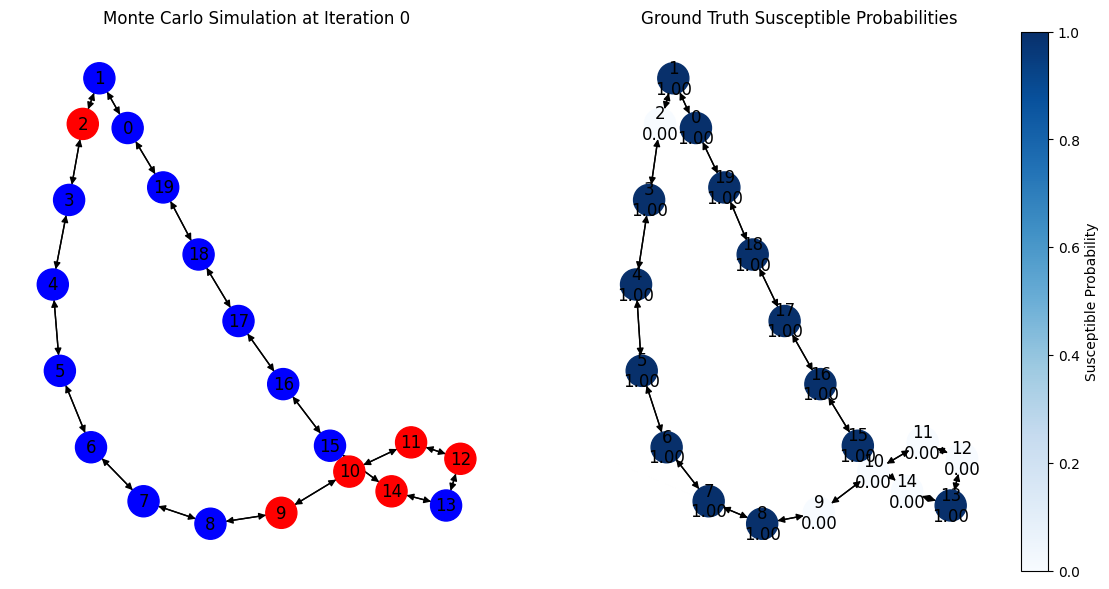

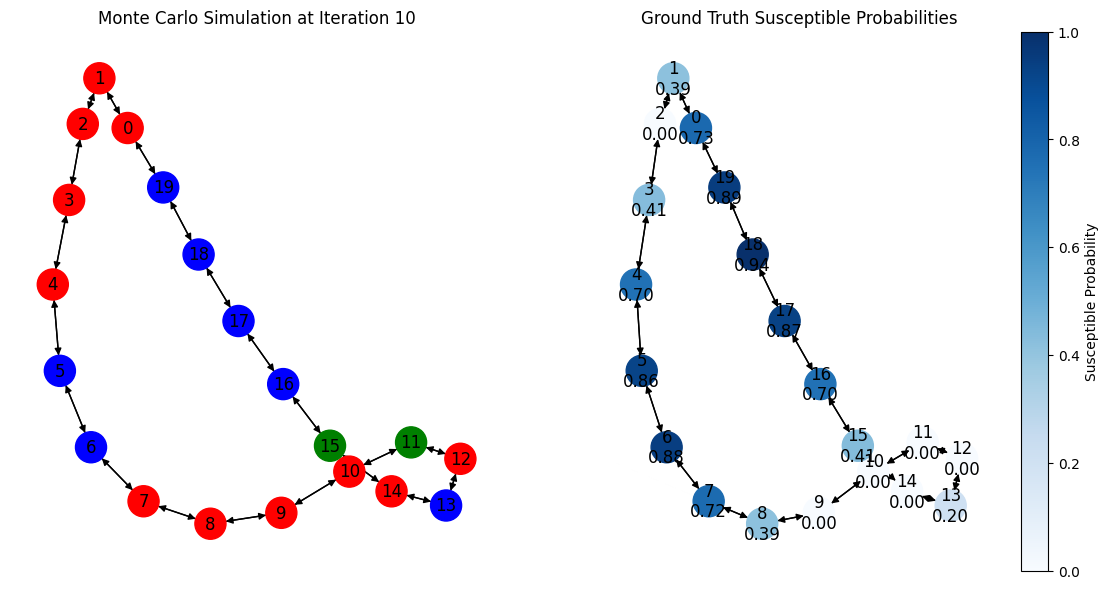

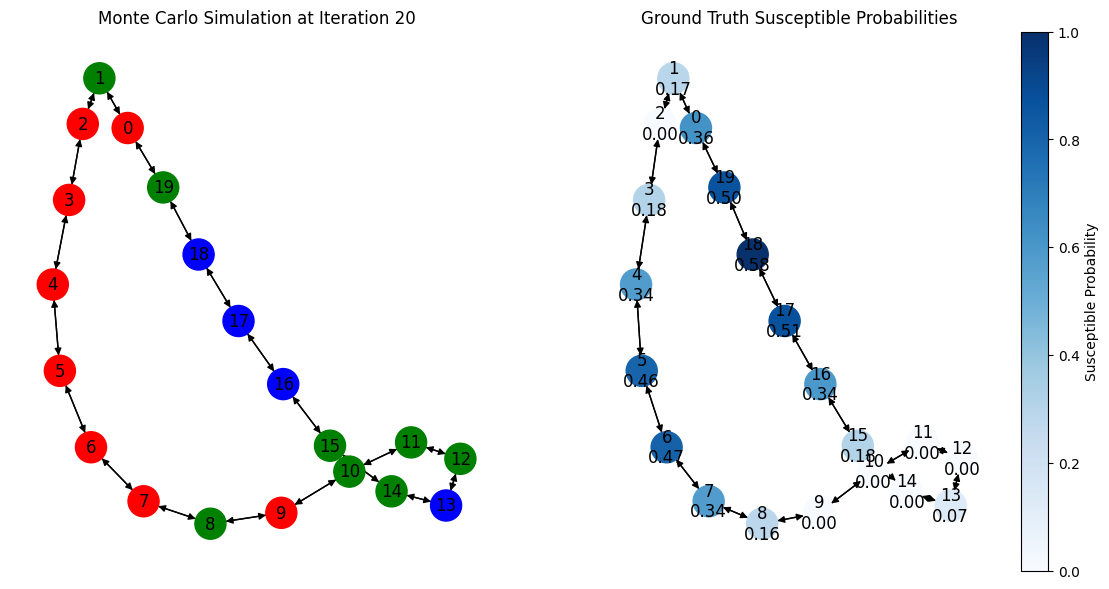

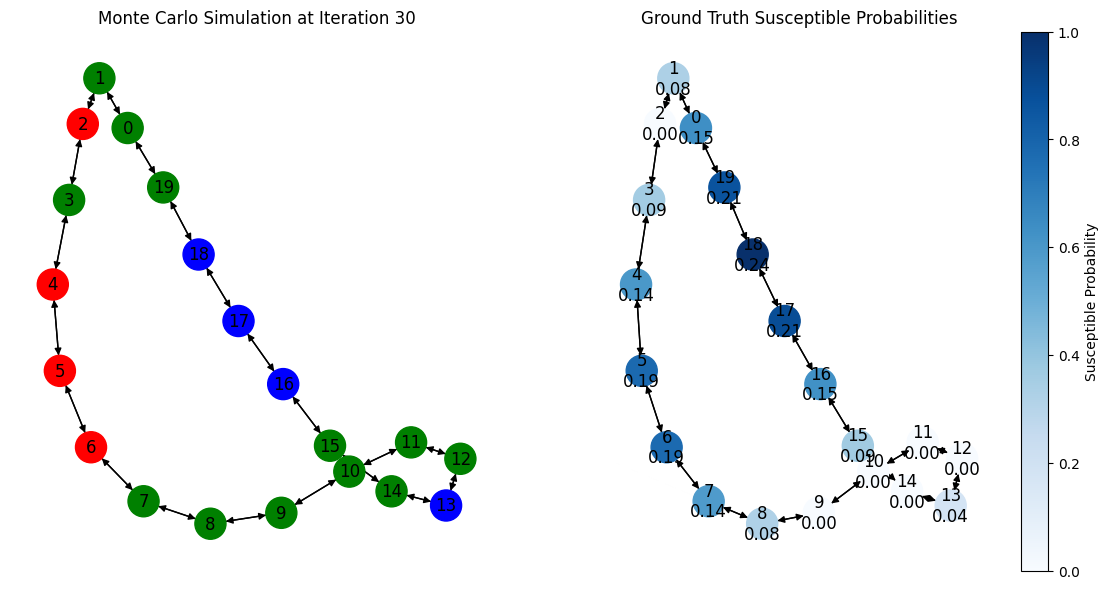

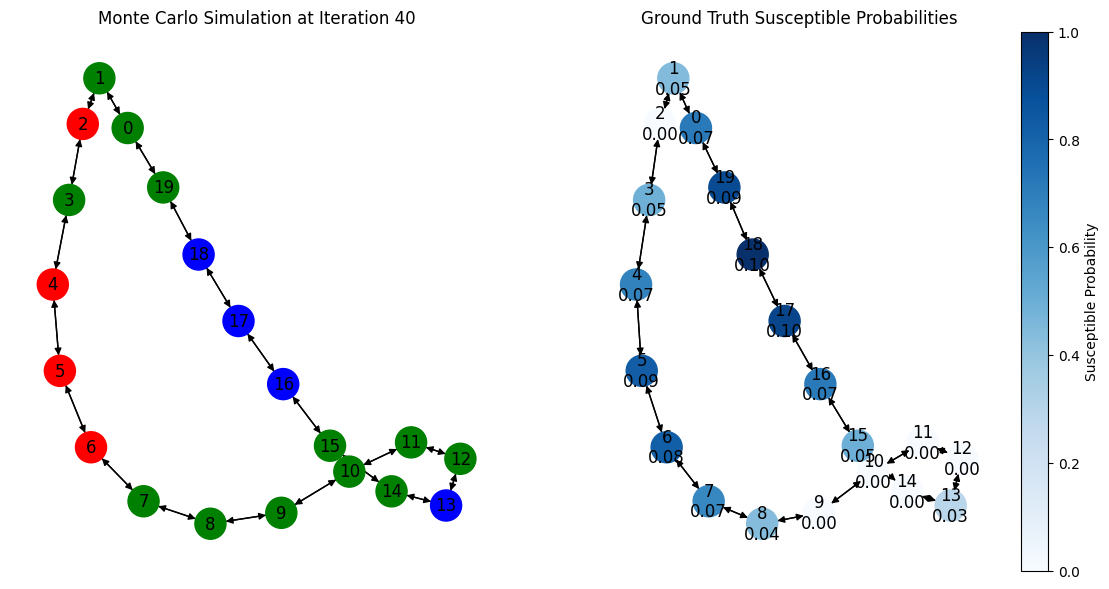

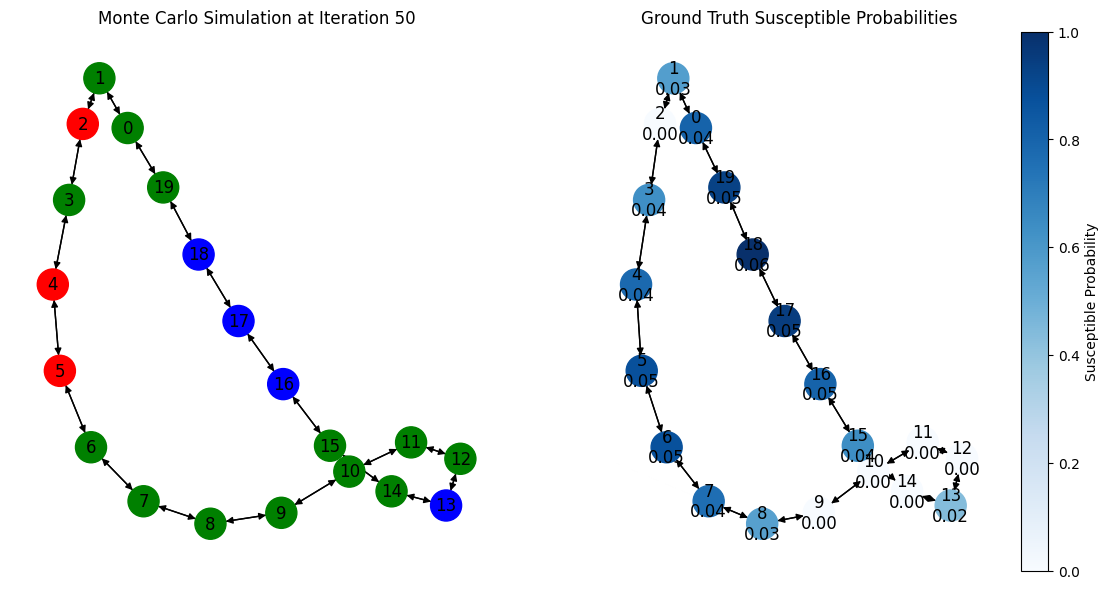

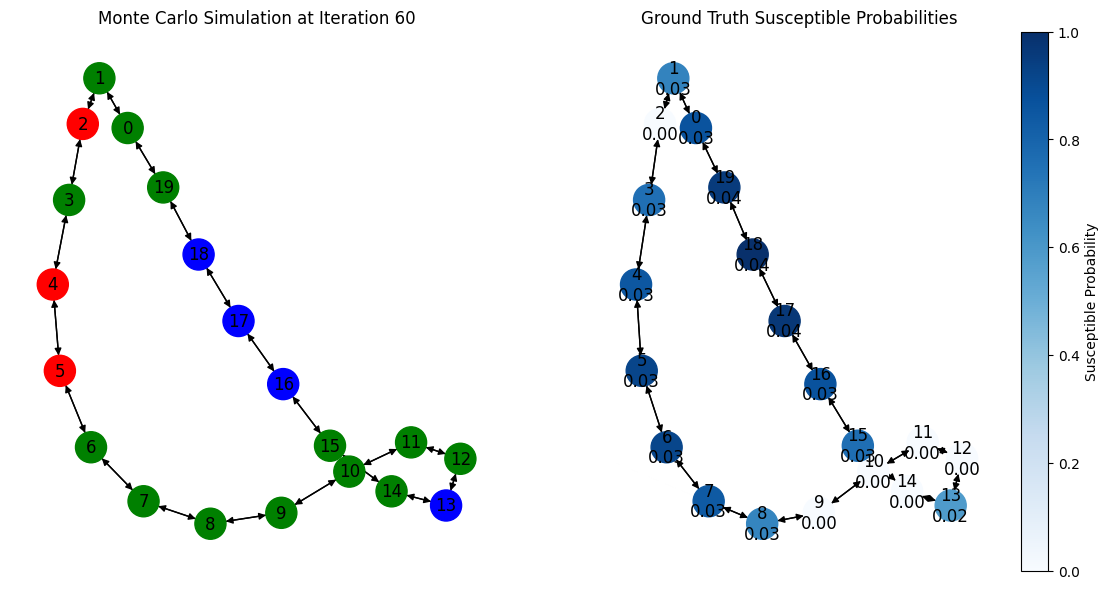

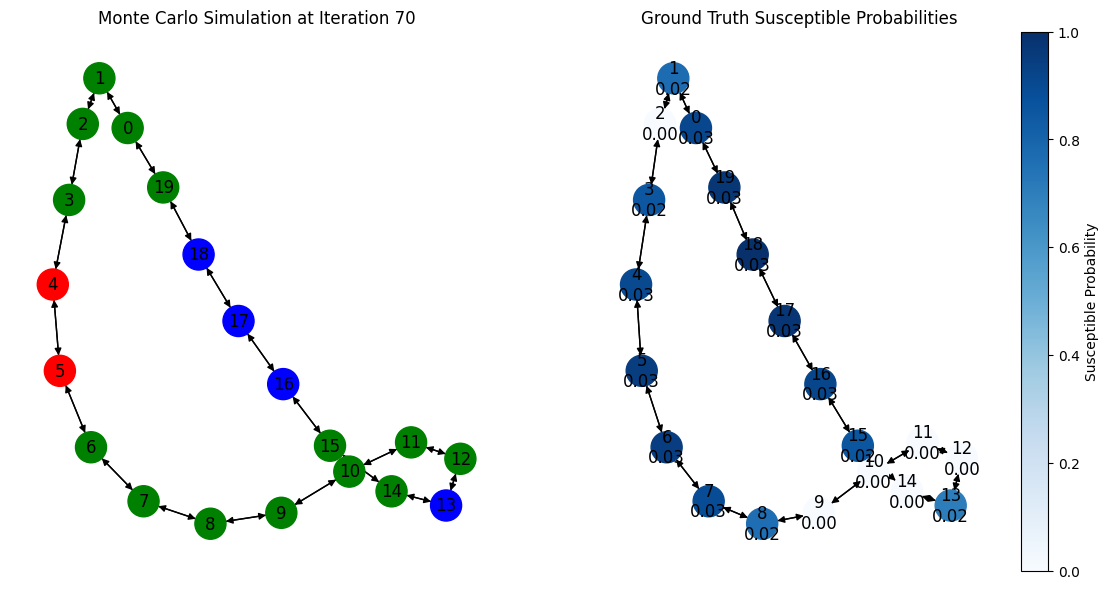

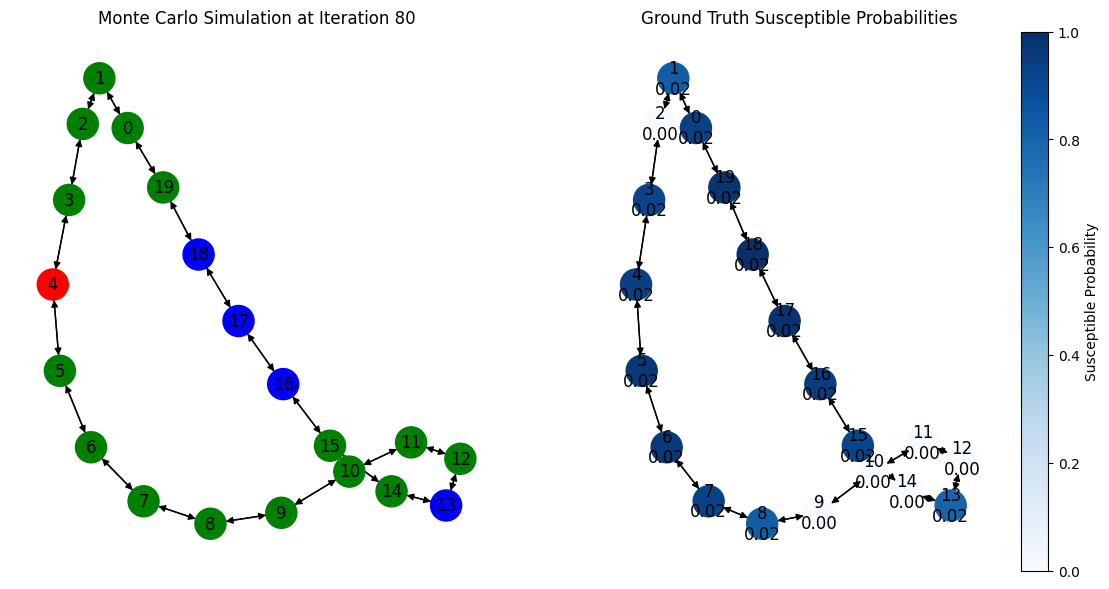

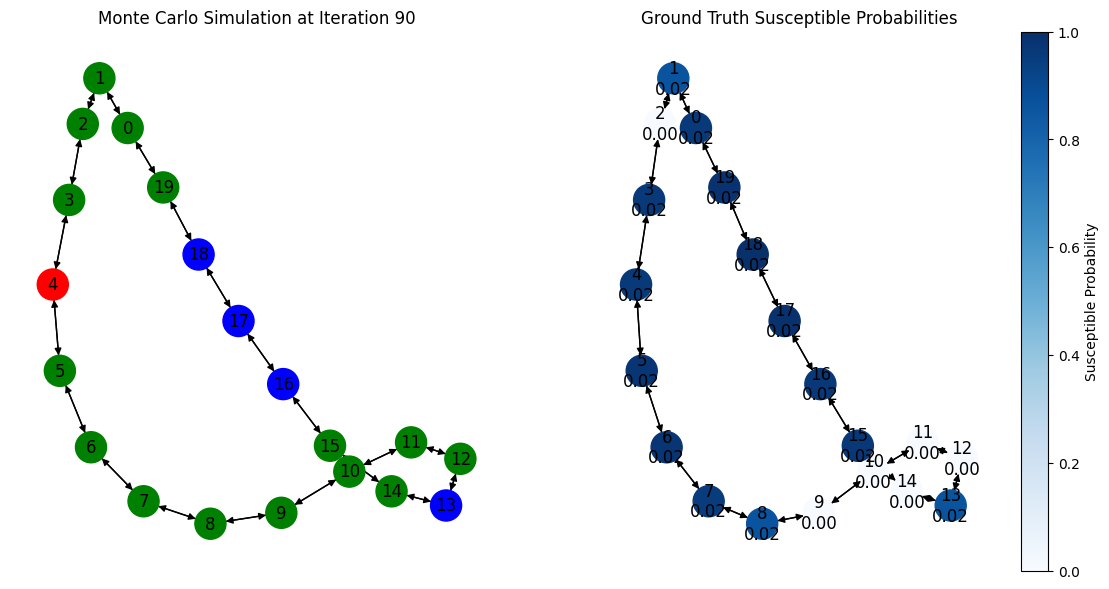

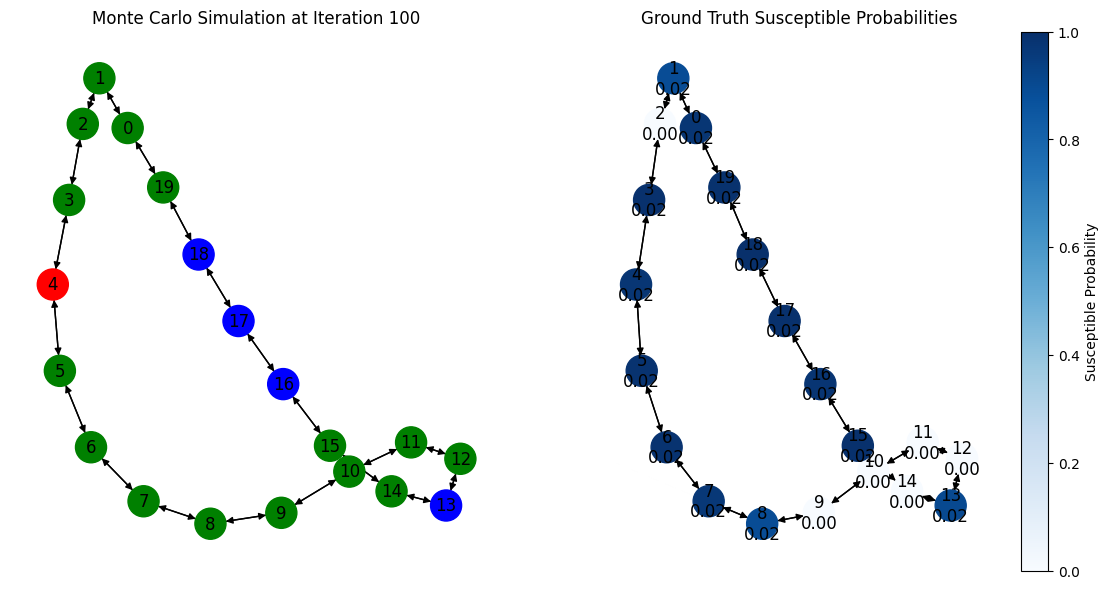

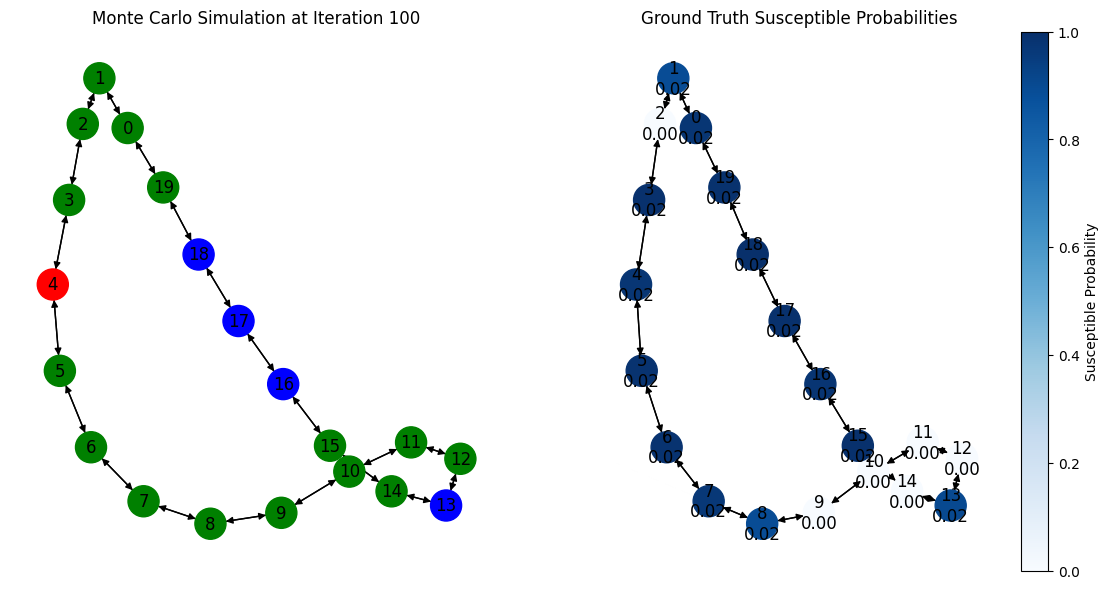

In [14]:
G = nx.watts_strogatz_graph(20, 3, 0.1).to_directed()
node_positions = nx.spring_layout(G)

beta = 0.1
gamma = 0.05
initial_infected_nodes = random.sample(list(G.nodes), 6)

monte_carlo_results = run_sir_simulation(G, beta, gamma, initial_infected_nodes)

ground_truth_results = conditional_probability_iteration(G, beta, gamma, initial_infected_nodes)

for iteration in range(0, len(monte_carlo_results), 10):
    visualize_iteration(G, monte_carlo_results, ground_truth_results, iteration, node_positions)

visualize_iteration(G, monte_carlo_results, ground_truth_results, len(monte_carlo_results) - 1, node_positions)

Ground Truth Susceptible Probabilities:
Node 0: 0.0185
Node 1: 0.0175
Node 2: 0.0000
Node 3: 0.0195
Node 4: 0.0186
Node 5: 0.0186
Node 6: 0.0186
Node 7: 0.0185
Node 8: 0.0175
Node 9: 0.0000
Node 10: 0.0000
Node 11: 0.0000
Node 12: 0.0000
Node 13: 0.0183
Node 14: 0.0000
Node 15: 0.0195
Node 16: 0.0186
Node 17: 0.0186
Node 18: 0.0187
Node 19: 0.0186


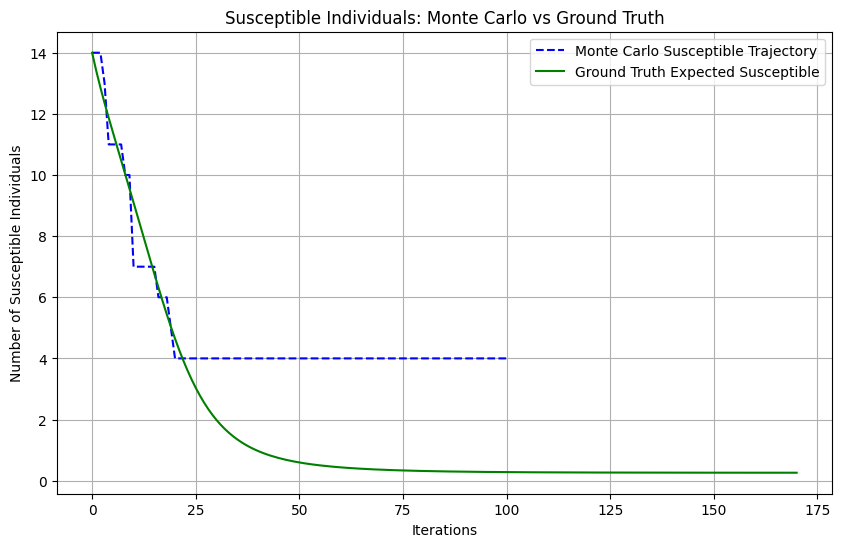

In [15]:
ground_truth_s = ground_truth_results[-1]['susceptible']
print("Ground Truth Susceptible Probabilities:")
for node, prob in ground_truth_s.items():
    print(f"Node {node}: {prob:.4f}")

mc_susceptible_trajectory = [
    sum(1 for state in result['status'].values() if state == 0) for result in monte_carlo_results
]

ground_truth_s_trajectory = [
    sum(result['susceptible'].values()) for result in ground_truth_results
]

plt.figure(figsize=(10, 6))
plt.plot(mc_susceptible_trajectory, label='Monte Carlo Susceptible Trajectory', color='blue', linestyle='--')
plt.plot(ground_truth_s_trajectory, label='Ground Truth Expected Susceptible', color='green', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Number of Susceptible Individuals')
plt.title('Susceptible Individuals: Monte Carlo vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()